# Problem 18: COVID-19 USA (total value: 11 points)

_Version 1.1b_

This problem is a data cleaning and analysis task that exercises basic pandas, Numpy, and the graph ranking and analysis content of Notebook 11. It consists of five (5) exercises, numbered 0 through 4, worth a total of **11 points.**

- Exercise 0: 3 points
- Exercise 1: 2 points
- Exercise 2: 1 point
- Exercise 3: 3 points
- Exercise 4: 2 points

**All exercises are independent, so if you get stuck on one, try moving on to the next one.** However, in such cases do look for notes labeled, _"In case Exercise XXX isn't working"_, as you may need to run some code cells that load pre-computed results that will allow you to continue with any subsequent exercises.

**Pro-tips.**
- If your program behavior seem strange, try resetting the kernel and rerunning everything.
- If you mess up this notebook or just want to start from scratch, save copies of all your partial responses and use `Actions` $\rightarrow$ `Reset Assignment` to get a fresh, original copy of this notebook. (_Resetting will wipe out any answers you've written so far, so be sure to stash those somewhere safe if you intend to keep or reuse them!_)
- If you generate excessive output (e.g., from an ill-placed `print` statement) that causes the notebook to load slowly or not at all, use `Actions` $\rightarrow$ `Clear Notebook Output` to get a clean copy. The clean copy will retain your code but remove any generated output. **However**, it will also **rename** the notebook to `clean.xxx.ipynb`. Since the autograder expects a notebook file with the original name, you'll need to rename the clean notebook accordingly.

**Good luck!**

## Background: Transportation networks and infectious disease

One major factor in the spread of infectious diseases like [COVID-19](https://www.cdc.gov/coronavirus/2019-nCoV/index.html) is the connectivity of our transportation networks. Therefore, let's ask the following question in this problem: to what extent does the connectivity of the airport network help explain in which regions we have seen the most confirmed cases of COVID-19?

We'll focus on the United States network (recall Notebook 11) and analyze data at the level of US states (e.g., Washington state, California, New York state). Our analysis will have three main steps.

1. Let's start by inspecting some recent COVID-19 data on the number of confirmed cases over time, to see which states are seeing the most cases.
2. Next, let's (re-)analyze the airport network to rank the states by their likelihood of seeing air traffic.
3. Finally, we'll compare the state ranking by incidence of COVID-19 with those by airport traffic, to see if there is any "correlation" between the two. We don't expect perfect overlap in these rankings, but if there is substantial overlap, it would provide evidence for the role that air transportation networks play in the spread of the disease.

Before starting, run the code cell below to load some useful functions and packages.

In [1]:
import sys
print(sys.version)

# Needed for loading data:
import pandas as pd
print(f"Pandas version: {pd.__version__}")

# Some problem-specific helper functions:
import problem_utils
from problem_utils import get_path, assert_tibbles_are_equivalent

# For visualization:
from matplotlib.pyplot import figure, plot, semilogy, grid, legend
%matplotlib inline

3.8.7 (default, Jan 25 2021, 11:14:52) 
[GCC 5.5.0 20171010]
Pandas version: 1.4.0


## Step 1: Inspecting COVID-19 incidence data by state

Researchers at Johns Hopkins University have been tallying the number of confirmed cases of COVID-19 over time. Let's start by assembling the raw data for analysis.

> *Provenance of these data.* JHU made these data are available in [this repo on GitHub](https://github.com/CSSEGISandData/COVID-19), but for this problem, we'll use a pre-downloaded copy.

**Location of the data.** The data are stored in files, one for each day since January 22, 2020. We can use pandas's [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_csv.html) to load them into a `DataFrame` object. For example, here is some code to do that for January 22, March 11, and March 22. Take a moment to read this code and observe the output:

In [2]:
print("Location of data files:", get_path('covid19/'))
print("Location of Jan 22 data:", get_path('covid19/01-22-2020.csv'))
print("Loading...")
df0 = pd.read_csv(get_path('covid19/01-22-2020.csv'))
print("Done loading. The first 5 rows:")
df0.head(5)

Location of data files: ./resource/asnlib/publicdata/covid19/
Location of Jan 22 data: ./resource/asnlib/publicdata/covid19/01-22-2020.csv
Loading...
Done loading. The first 5 rows:


,Province/State,Country/Region,Last Update,Confirmed,Deaths,Recovered
0,Anhui,Mainland China,1/22/2020 17:00,1.0,NaN,NaN
1,Beijing,Mainland China,1/22/2020 17:00,14.0,NaN,NaN
2,Chongqing,Mainland China,1/22/2020 17:00,6.0,NaN,NaN
3,Fujian,Mainland China,1/22/2020 17:00,1.0,NaN,NaN
4,Gansu,Mainland China,1/22/2020 17:00,NaN,NaN,NaN


In [3]:
df1 = pd.read_csv(get_path('covid19/03-11-2020.csv'))
df1.head(5)

,Province/State,Country/Region,Last Update,Confirmed,Deaths,Recovered,Latitude,Longitude
0,Hubei,China,2020-03-11T10:53:02,67773,3046,49134,30.9756,112.2707
1,NaN,Italy,2020-03-11T21:33:02,12462,827,1045,43.0000,12.0000
2,NaN,Iran,2020-03-11T18:52:03,9000,354,2959,32.0000,53.0000
3,NaN,"Korea, South",2020-03-11T21:13:18,7755,60,288,36.0000,128.0000
4,France,France,2020-03-11T22:53:03,2281,48,12,46.2276,2.2137


In [4]:
df2 = pd.read_csv(get_path('covid19/03-22-2020.csv'))
df2.head(5)

,FIPS,Admin2,Province_State,Country_Region,Last_Update,Lat,Long_,Confirmed,Deaths,Recovered,Active,Combined_Key
0,36061.0,New York City,New York,US,3/22/20 23:45,40.767273,-73.971526,9654,63,0,0,"New York City, New York, US"
1,36059.0,Nassau,New York,US,3/22/20 23:45,40.740665,-73.589419,1900,4,0,0,"Nassau, New York, US"
2,36119.0,Westchester,New York,US,3/22/20 23:45,41.162784,-73.757417,1873,0,0,0,"Westchester, New York, US"
3,36103.0,Suffolk,New York,US,3/22/20 23:45,40.883201,-72.801217,1034,9,0,0,"Suffolk, New York, US"
4,36087.0,Rockland,New York,US,3/22/20 23:45,41.150279,-74.025605,455,1,0,0,"Rockland, New York, US"


**Columns.** Observe that the column conventions are changing over time, which will make working with this data quite messy if we don't deal with it.

In this problem, we will only be interested in the following four columns:

- `"Province/State"` or `"Province_State"`. If your code encounters the latter (`"Province_State"`), rename it to the former (`"Province/State"`).
- `"Country/Region"` or `"Country_Region"`. Again, rename instances of the latter to the former.
- `"Last Update"` or `"Last_Update"`. Again, rename the latter to the former.
- `"Confirmed"`. This column is named consistently for all the example data.

**Missing values.** Observe that there may be missing values, which `read_csv()` converts by default to "not-a-number" (`NaN`) values. Recall that these are special floating-point values. As a by-product of using `NaN` values in columns that otherwise contain integers, those integers are *also* converted to floating-point.

**Timestamps.** Observe that each dataframe has a column named `"Last Update"`, which contain date and time values stored as _strings_. Moreover, they appear to use different formats. Later, we'll want to standardize these, and for that purpose, we'll use pandas's [`to_datetime()`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.to_datetime.html) to convert these into Python [`datetime`](https://docs.python.org/3/library/datetime.html) objects. That makes them easier to compare (in code) and do simple arithmetic on them (e.g., calculate the number of days in-between). The following code cells demonstrate these features.

In [5]:
print(type(df1['Last Update'].loc[0])) # Confirm that these values are strings

# Example: Convert a column to use `datetime` values:
df0['Timestamp'] = pd.to_datetime(df0['Last Update'])
df1['Timestamp'] = pd.to_datetime(df1['Last Update'])
df1.head(5)

<class 'str'>


,Province/State,Country/Region,Last Update,Confirmed,Deaths,Recovered,Latitude,Longitude,Timestamp
0,Hubei,China,2020-03-11T10:53:02,67773,3046,49134,30.9756,112.2707,2020-03-11 10:53:02
1,NaN,Italy,2020-03-11T21:33:02,12462,827,1045,43.0000,12.0000,2020-03-11 21:33:02
2,NaN,Iran,2020-03-11T18:52:03,9000,354,2959,32.0000,53.0000,2020-03-11 18:52:03
3,NaN,"Korea, South",2020-03-11T21:13:18,7755,60,288,36.0000,128.0000,2020-03-11 21:13:18
4,France,France,2020-03-11T22:53:03,2281,48,12,46.2276,2.2137,2020-03-11 22:53:03


In [6]:
# Example: Calcuate the difference, in days, between two timestamps
timestamp_0 = df1['Timestamp'].iloc[0]
timestamp_1 = df1['Timestamp'].iloc[1]
delta_t = timestamp_1 - timestamp_0

print(f"* {timestamp_0}  ==> type: {type(timestamp_0)}")
print(f"* {timestamp_1}  ==> type: {type(timestamp_1)}")
print(f"* Difference: ({timestamp_1}) - ({timestamp_0}) == {delta_t}\n  ==> type: {type(delta_t)})")

* 2020-03-11 10:53:02  ==> type: <class 'pandas._libs.tslibs.timestamps.Timestamp'>
* 2020-03-11 21:33:02  ==> type: <class 'pandas._libs.tslibs.timestamps.Timestamp'>
* Difference: (2020-03-11 21:33:02) - (2020-03-11 10:53:02) == 0 days 10:40:00
  ==> type: <class 'pandas._libs.tslibs.timedeltas.Timedelta'>)


You won't need to do date-time arithmetic directly, but standardizing in this way will facilitate things like sorting the data by timestamp.

**Getting a list of available data files.** Lastly, here is a function to get a list of available daily data files by filename. You don't need to read this code, but do observe the results of the demo call to see how it is useful.

In [7]:
def get_covid19_daily_filenames(root=get_path("covid19/")):
    """
    Returns a list of file paths corresponding to JHU's
    daily tallies of COVID-19 cases.
    """
    from os import listdir
    from os.path import isfile
    from re import match
    
    def covid19_filepath(filebase, root):
        return f"{root}{filebase}"
    
    def is_covid19_daily_file(filebase, root):
        file_path = covid19_filepath(filebase, root)
        return isfile(file_path) and match('^\d\d-\d\d-2020.csv$', filebase)
    
    filenames = []
    for b in listdir(root):
        if is_covid19_daily_file(b, root):
            filenames.append(covid19_filepath(b, root))
    return sorted(filenames)

# Demo:
print(repr(get_covid19_daily_filenames()))

['./resource/asnlib/publicdata/covid19/01-22-2020.csv', './resource/asnlib/publicdata/covid19/01-23-2020.csv', './resource/asnlib/publicdata/covid19/01-24-2020.csv', './resource/asnlib/publicdata/covid19/01-25-2020.csv', './resource/asnlib/publicdata/covid19/01-26-2020.csv', './resource/asnlib/publicdata/covid19/01-27-2020.csv', './resource/asnlib/publicdata/covid19/01-28-2020.csv', './resource/asnlib/publicdata/covid19/01-29-2020.csv', './resource/asnlib/publicdata/covid19/01-30-2020.csv', './resource/asnlib/publicdata/covid19/01-31-2020.csv', './resource/asnlib/publicdata/covid19/02-01-2020.csv', './resource/asnlib/publicdata/covid19/02-02-2020.csv', './resource/asnlib/publicdata/covid19/02-03-2020.csv', './resource/asnlib/publicdata/covid19/02-04-2020.csv', './resource/asnlib/publicdata/covid19/02-05-2020.csv', './resource/asnlib/publicdata/covid19/02-06-2020.csv', './resource/asnlib/publicdata/covid19/02-07-2020.csv', './resource/asnlib/publicdata/covid19/02-08-2020.csv', './resour

### Exercise 0 (3 points): Data loading and cleaning ###

Given `filenames`, a list of filenames that might be generated by `get_covid19_filenames()` above, complete the function `load_covid19_daily_data(filenames)` below so that it reads all of this data and combines it into a single tibble (as a pandas `DataFrame`) containing only the following columns:

* `"Province/State"`: Same contents as the original data frames.
* `"Country/Region"`: Same contents as the original data frames.
* `"Confirmed"`: Same contents as the original data frames.
* `"Timestamp"`: The values from the `"Last Update"` columns, but **converted** to `datetime` objects per the demonstration discussed previously.

In addition, your code should do the following:

1. Don't forget that sometimes `"Province/State"`, `"Country/Region"`, and `"Last Update"` are written differently, so be sure to handle those cases.
1. If there are any duplicate rows (i.e., two or more rows whose values are identical), only one of the rows should be retained.
1. In the `"Confirmed"` column, any missing values should be replaced by (0). Also, this column should be converted to have an integer type. (_Hint:_ Consider `Series.fillna()` and `Series.astype()`.)
1. Your code should *not* depend on the input files having any specific columns other than the ones directly relevant to producing the above output, i.e., `"Province/State"`, `"Country/Region"`, `"Confirmed"`, and `"Last Update"`. It should also not depend on any particular ordering of the columns.

> **Hint 0.** Per the preceding examples, use `pd.read_csv()` to read the contents of each file into a data frame. However, the `filenames` list will already include a valid path, so you do **not** need to use `get_path()`.
>
> **Hint 1.** Recall that you can use `pd.concat()` to concatenate data frames; one tweak in here is to use its `ignore_index=True` parameter to get a clean tibble-like index.
>
> **Hint 2.** To easily drop duplicate rows, look for a relevant pandas built-in function.

In [8]:
display((pd.read_csv(get_covid19_daily_filenames()[20])))

,Province/State,Country/Region,Last Update,Confirmed,Deaths,Recovered
0,Hubei,Mainland China,2020-02-11T23:33:02,33366,1068,2639
1,Guangdong,Mainland China,2020-02-11T14:03:05,1177,1,212
2,Zhejiang,Mainland China,2020-02-11T12:53:02,1117,0,270
3,Henan,Mainland China,2020-02-11T14:03:05,1105,7,218
4,Hunan,Mainland China,2020-02-11T12:53:02,912,1,247
...,...,...,...,...,...,...
68,"Madison, WI",US,2020-02-05T21:53:02,1,0,0
69,"Orange, CA",US,2020-02-01T19:53:03,1,0,0
70,"San Diego County, CA",US,2020-02-11T01:23:05,1,0,0
71,"Seattle, WA",US,2020-02-09T07:03:04,1,0,1


In [9]:
df_list = [pd.read_csv(i).rename(columns=lambda x: x.title().replace('_', '/').replace(' ', '/')).rename(columns={'Last/Update': 'Timestamp'}) for i in get_covid19_daily_filenames()]
df_short = [df[['Province/State', 'Country/Region', 'Confirmed', 'Timestamp']] for df in df_list]

# for d in df_short:
#     print(d.columns)

# pd.concat(df_short, ignore_index=True)

In [10]:
def load_covid19_daily_data(filenames):
    df_list = [pd.read_csv(i).rename(columns=lambda x: x.title().replace('_', '/').replace(' ', '/')).rename(columns={'Last/Update': 'Timestamp'}) for i in filenames]
    df_short = [df[['Province/State', 'Country/Region', 'Confirmed', 'Timestamp']] for df in df_list]
    df = pd.concat(df_short, ignore_index=True)
    df['Timestamp'] = pd.to_datetime(df['Timestamp'])
    df['Confirmed'] = df['Confirmed'].fillna(0)
    df['Confirmed'] = df['Confirmed'].astype(int)
    return df.drop_duplicates()


In [11]:
# Demo of your function:
df = load_covid19_daily_data(get_covid19_daily_filenames())

print(f"There are {len(df)} rows in your data frame.")
print("The first five are:")
display(df.head(5))

print("A random sample of five additional rows:")
df.sample(5).sort_index()

There are 7588 rows in your data frame.
The first five are:


,Province/State,Country/Region,Confirmed,Timestamp
0,Anhui,Mainland China,1,2020-01-22 17:00:00
1,Beijing,Mainland China,14,2020-01-22 17:00:00
2,Chongqing,Mainland China,6,2020-01-22 17:00:00
3,Fujian,Mainland China,1,2020-01-22 17:00:00
4,Gansu,Mainland China,0,2020-01-22 17:00:00


A random sample of five additional rows:


,Province/State,Country/Region,Confirmed,Timestamp
3816,NaN,Kuwait,61,2020-03-07 18:13:26
4745,Beijing,China,435,2020-03-11 02:18:14
5027,NaN,Albania,23,2020-03-12 21:39:09
6496,NaN,Chile,238,2020-03-18 13:33:12
15218,Colorado,US,148,2020-03-24 23:37:31


In [12]:
# Test cell: `ex0__load_covid19_daily_data` (3 points)

###
### AUTOGRADER TEST - DO NOT REMOVE
###

def ex0_random_value():
    from random import random, randint, choice
    from numpy import nan
    from problem_utils import ex0_random_date, ex0_random_string
    options = [randint(-100, 100) # int
               , ex0_random_string(randint(1, 10)) # string
               , ex0_random_date(), # date
               '', # implicit NaN
               nan # explicit NaN
              ]
    return choice(options)

def ex0_get_locales(filename=get_path("locales.json")):
    from json import load
    with open(filename, "rt") as fp:
        locales = load(fp)
    return locales

def ex0_gen_row(locales, num_dummies=0):
    from datetime import datetime
    from random import choice, random, randint
    from numpy import nan
    from problem_utils import ex0_random_date
    country = choice(list(locales.keys()))
    province = nan if random() <= 0.1 else choice(locales[country])
    confirmed = 0 if random() <= 0.1 else randint(1, 100000)
    last_updated = ex0_random_date()
    if num_dummies:
        dummy_vals = tuple([ex0_random_value() for _ in range(num_dummies)])
    else:
        dummy_vals = ()
    return (country, province, confirmed, last_updated, *dummy_vals)
    
def ex0_gen_df():
    from random import randint, random
    from pandas import DataFrame
    from problem_utils import ex0_random_string
    
    locales = ex0_get_locales()

    # Generate random columns, which the student should ignore
    num_dummy_cols = randint(1, 4)
    dummy_cols = []
    while len(dummy_cols) != num_dummy_cols:
        dummy_cols = list({ex0_random_string(5) for _ in range(num_dummy_cols)})
    
    # Generate a bunch of random rows
    num_trials = randint(10, 50)
    rows = [ex0_gen_row(locales, num_dummy_cols) for _ in range(num_trials)]
    
    # Remove any initial duplicates
    rows = sorted(rows, key=lambda x: repr(x))
    rows_soln = [rows[0]]
    for r in rows[1:]:
        if repr(r) != repr(rows_soln[-1]):
            rows_soln.append(r)

    # Construct the solution tibble
    cols_in = ["Country/Region" if random() < 0.75 else "Country_Region",
               "Province/State" if random() < 0.75 else "Province_State",
               "Confirmed",
               "Last Update" if random() < 0.75 else "Last_Update"]
    cols_out = ["Country/Region", "Province/State", "Confirmed", "Last Update"]
    df_soln = DataFrame(rows_soln, columns=cols_out + dummy_cols)[cols_out] \
              .rename(columns={"Last Update": "Timestamp"})
    
    # Generate a corresponding input tibble
    rows_in = []
    for r in rows_soln:
        s = list(r)
        if s[2] == 0:
            s[2] = '' # NaN counts
        r_in = tuple(s)
        rows_in.append(r_in)
        if random() <= 0.15: # Random duplicates
            for _ in range(randint(1, 4)):
                rows_in.append(r_in)
    df_in = DataFrame(rows_in, columns=cols_in + dummy_cols)
    
    return df_in, df_soln

def ex0_split_df(df, max_splits=5):
    from random import randint
    from numpy import arange, sort, append
    from numpy.random import shuffle, choice
    # Shuffle the rows
    df = df.sample(frac=1).reset_index(drop=True)

    # Split the rows
    df_split = []
    num_splits = min(randint(0, max_splits), len(df))
    if num_splits > 0:
        split_inds = sort(choice(arange(len(df)), size=num_splits, replace=False))
        if split_inds[0] > 0:
            split_inds = append(0, split_inds)
        if split_inds[-1] < len(df):
            split_inds = append(split_inds, len(df))
        for i, j in zip(split_inds[:-1], split_inds[1:]):
            df_ij = df.iloc[i:j].reset_index(drop=True)  
            df_split.append(df_ij)
        
    return df_split if num_splits else [df]

def ex0_certify_metadata(df):
    df_cols = set(df.columns)
    true_cols = {"Province/State", "Country/Region", "Confirmed", "Timestamp"}
    too_many_cols = df_cols - true_cols
    assert not too_many_cols, f"*** You have too many columns, including {too_many_cols}. ***"
    missing_cols = true_cols - df_cols
    assert not missing_cols, f"*** You are missing some columns, namely, {missing_cols}. ***"

    from pandas.api.types import is_integer_dtype
    assert is_integer_dtype(df["Confirmed"]), \
           '*** `"Confirmed"` column has a non-integer type ({type(df["Confirmed"])}). ***'
    
    from numpy import datetime64
    from pandas import Index
    assert df.select_dtypes(include=datetime64).columns == Index(["Timestamp"]), \
           '*** Your data frame must have a "Timestamp" column containing `datetime` values.'
    
def ex0_check():
    from problem_utils import canonicalize_tibble, tibbles_left_matches_right
    from os import remove
    from os.path import isfile
    print("Generating synthetic input files...")
    df_in, df_soln = ex0_gen_df()
    df_split = ex0_split_df(df_in)
    filenames = []
    for k, df_k in enumerate(df_split):
        filenames.append(f'./ex0_df{k}.csv')
        print(f"- {filenames[-1]}")
        df_k.to_csv(filenames[-1], index=False)
    try:
        print("Testing your solution...")
        df = load_covid19_daily_data(filenames)
        ex0_certify_metadata(df)
        assert tibbles_left_matches_right(df, df_soln, verbose=True), \
               "*** Your computed solution does not match ours. ***"
    except:
        print("\n=== Expected solution ===")
        display(canonicalize_tibble(df_soln, remove_index=True))
        print("\n=== Your computed solution ===")
        display(canonicalize_tibble(df, remove_index=True))
        print(f"\nNOTE: To see the original input files, inspect {filenames}.")
        raise
    else:
        print("Cleaning up input files...")
        for f in filenames:
            if isfile(f):
                print(f"- {f}")
                remove(f)
        
        
for trial in range(5):
    print(f"========== Trial #{trial} ==========")
    ex0_check()

print("\n(Passed.)")

========== Trial #0 ==========
Generating synthetic input files...
- ./ex0_df0.csv
Testing your solution...
Cleaning up input files...
- ./ex0_df0.csv
========== Trial #1 ==========
Generating synthetic input files...
- ./ex0_df0.csv
- ./ex0_df1.csv
- ./ex0_df2.csv
- ./ex0_df3.csv
Testing your solution...
Cleaning up input files...
- ./ex0_df0.csv
- ./ex0_df1.csv
- ./ex0_df2.csv
- ./ex0_df3.csv
========== Trial #2 ==========
Generating synthetic input files...
- ./ex0_df0.csv
- ./ex0_df1.csv
- ./ex0_df2.csv
- ./ex0_df3.csv
- ./ex0_df4.csv
Testing your solution...
Cleaning up input files...
- ./ex0_df0.csv
- ./ex0_df1.csv
- ./ex0_df2.csv
- ./ex0_df3.csv
- ./ex0_df4.csv
========== Trial #3 ==========
Generating synthetic input files...
- ./ex0_df0.csv
- ./ex0_df1.csv
- ./ex0_df2.csv
- ./ex0_df3.csv
- ./ex0_df4.csv
- ./ex0_df5.csv
Testing your solution...
Cleaning up input files...
- ./ex0_df0.csv
- ./ex0_df1.csv
- ./ex0_df2.csv
- ./ex0_df3.csv
- ./ex0_df4.csv
- ./ex0_df5.csv
========== T

### A combined data frame ###

Whether you solved Exercise 0 or not, we have prepared a file of pre-cleaned and combined COVID-19 data. Below, the variable `df_covid19` holds these data. You will need it in the subsequent exercises, so be sure to run this cell and do not modify the variable!

In [13]:
df_covid19 = pd.read_csv(get_path('covid19/ex0_soln.csv'), parse_dates=["Timestamp"])
df_covid19 = df_covid19.groupby(["Province/State", "Country/Region", "Timestamp"], as_index=False).sum()
             # ^^^ Above `.groupby()` needed because of a change in US reporting on March 22, 2020
df_covid19.sample(5)

,Province/State,Country/Region,Timestamp,Confirmed
2668,Sichuan,Mainland China,2020-01-22 17:00:00,5
3038,Virginia,US,2020-03-18 19:53:03,77
1486,Jiangsu,Mainland China,2020-02-14 10:03:03,593
1347,Illinois,US,2020-01-27 23:59:00,1
1656,"Lackland, TX (From Diamond Princess)",US,2020-02-22 17:13:24,2


### US state-by-state data ###

The dataset includes confirmed cases in the US. For instance, run this cell to see a sample of the US rows.

In [14]:
is_us = (df_covid19["Country/Region"] == "US")
df_covid19[is_us].sample(5)

,Province/State,Country/Region,Timestamp,Confirmed
1945,Nevada,US,2020-03-11 20:00:00,17
2851,Tennessee,US,2020-03-21 23:13:18,371
2052,New York,US,2020-03-19 23:43:04,5365
489,"Douglas County, OR",US,2020-03-08 19:53:03,1
520,Florida,US,2020-03-18 19:14:34,314


You should see some cases where the `"Province/State"` field is exactly the name of a US state, like `"Georgia"` or `"California"`, and other cases where you might see a more or less detailed location (e.g., a city name and a statee, like `"Middlesex County, MA"`).

For subsequent analysis, we will only be interested in the rows containing **state names**. For instance, here are all the rows associated with `"Georgia"`.

In [15]:
is_georgia = (df_covid19["Province/State"] == "Georgia")
df_covid19[is_us & is_georgia]

,Province/State,Country/Region,Timestamp,Confirmed
676,Georgia,US,2020-03-10 03:53:03,17
677,Georgia,US,2020-03-11 18:52:03,23
678,Georgia,US,2020-03-11 20:00:00,42
679,Georgia,US,2020-03-12 21:39:10,31
680,Georgia,US,2020-03-14 17:53:03,66
681,Georgia,US,2020-03-15 18:20:19,99
682,Georgia,US,2020-03-16 16:53:06,121
683,Georgia,US,2020-03-17 20:13:22,146
684,Georgia,US,2020-03-18 19:14:34,199
685,Georgia,US,2020-03-19 21:13:35,287


Given these data, we can order by timestamp and plot confirmed cases over time.

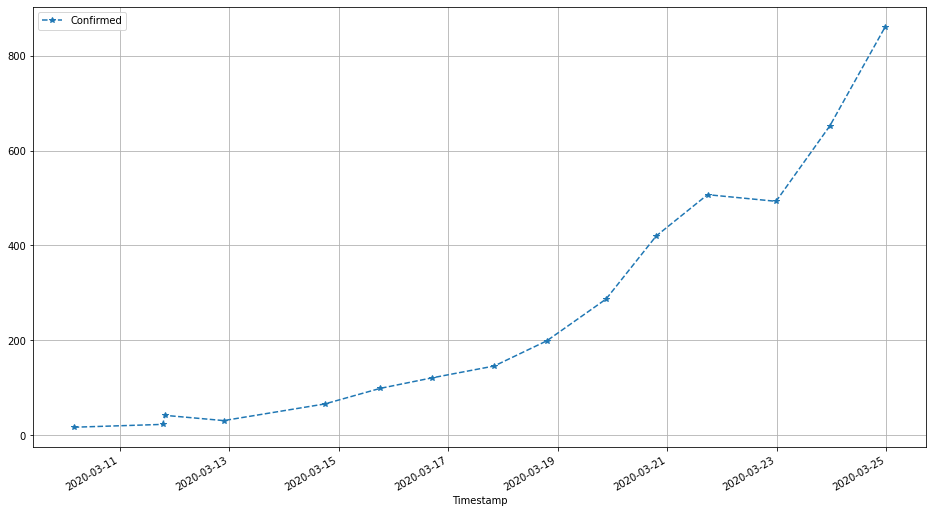

In [16]:
df_covid19[is_us & is_georgia] \
    .sort_values(by="Timestamp") \
    .plot(x="Timestamp", y="Confirmed", figsize=(16, 9), style='*--')
grid()

### Exercise 1 (2 points): US state-by-state data

Complete the function, `get_us_states(df)`, below, where

- its input, `df`, is a data frame structured like the combined COVID-19 data frame (`df_covid19`), having the columns `"Province/State"`, `"Country/Region"`, `"Confirmed"`, `"Timestamp"`;
- and it returns a tibble containing only those rows of `df` that are from the United States where the `"Province/State"` field is exactly the name of any one of the US states.

Regarding the second requirement, the returned object should include a row where the `"Province/State"` field is `"Georgia"`, but it should **not** include a row where this field is, say, `"Atlanta, GA"`. (Put differently, we will assume the state-level accounts already include city-level counts.)

The tibble returned by your function should only have these three columns:

1. `"Confirmed"`: The number of confirmed cases, taken from the input `df`.
2. `"Timestamp"`: The timestamp taken from the input `df`.
3. `"ST"`: The two-letter **abbreviation** for the state's name.

Pay attention to item (3): your returned tibble should not have the state's full name, but rather, its two-letter postal code abbreviation (e.g., `"GA"` instead of `"Georgia"`). To help you out, here is a code cell that defines a data frame called `STATE_NAMES` that holds both a list of state names and their two-letter abbreviations.

> **Note**: The test cell for this exercise reuses functions defined in the test cell for Exercise 0. So even if you skipped Exercise 0, please run its test cell before running the one below.

In [17]:
STATE_NAMES = pd.read_csv(get_path('us_states.csv'))
print(f"There are {len(STATE_NAMES)} US states. The first and last three, along with their two-letter postal code abbreviations, are as follows (in alphabetical order):")
display(STATE_NAMES.head(3))
print("...")
display(STATE_NAMES.tail(3))

There are 50 US states. The first and last three, along with their two-letter postal code abbreviations, are as follows (in alphabetical order):


,Name,Abbrv
0,Alabama,AL
1,Alaska,AK
2,Arizona,AZ


...


,Name,Abbrv
47,West Virginia,WV
48,Wisconsin,WI
49,Wyoming,WY


In [18]:
# display(df_covid19.merge(STATE_NAMES, left_on = 'Province/State', right_on = 'Name', how='inner'))
us_df = df_covid19.merge(STATE_NAMES, left_on = 'Province/State', right_on = 'Name', how='inner')
df = us_df[['Confirmed', 'Timestamp', 'Abbrv']]
display(df.rename(columns = {'Abbrv': 'ST'})  ) 

,Confirmed,Timestamp,ST
0,5,2020-03-11 20:00:00,AL
1,6,2020-03-14 16:53:03,AL
2,12,2020-03-15 18:20:19,AL
3,29,2020-03-16 22:33:03,AL
4,39,2020-03-17 23:13:10,AL
...,...,...,...
700,19,2020-03-20 22:14:43,WY
701,23,2020-03-21 19:43:03,WY
702,23,2020-03-22 23:45:00,WY
703,23,2020-03-23 23:19:34,WY


In [19]:
def get_us_states(df):
    ###
    us_df = df[df['Country/Region'] == 'US']
    states_df = us_df.merge(STATE_NAMES, left_on = 'Province/State', right_on = 'Name', how='inner')
    final_df = states_df[['Confirmed', 'Timestamp', 'Abbrv']]
    return final_df.rename(columns = {'Abbrv': 'ST'}).drop_duplicates()                             
    ###


In [20]:
# Test cell: `ex1__get_us_states` (2 points)

###
### AUTOGRADER TEST - DO NOT REMOVE
###

def ex1_gen_row(states):
    from datetime import datetime
    from random import random, randint, choice
    from problem_utils import ex0_random_date, ex0_random_string
    def rand_str(): return ex0_random_string(randint(1, 10))
    
    confirmed = randint(1, 10000)
    timestamp = ex0_random_date()
    
    # Choose a province
    locales = ex0_get_locales()
    p = random()
    if p < 0.5: # Non US country
        country = choice(list(set(locales.keys()) - {"US"}))
        province = choice(locales[country])
        is_state = False
    else:
        country = "US"
        if p < 0.75:
            non_states = set(locales["US"]) - set(states["Name"])
            province = choice(list(non_states))
            is_state = False
        else:
            province = choice(states["Name"])
            is_state = True
    return timestamp, confirmed, country, province, is_state

def ex1_gen_df(max_rows, states):
    from random import randint
    from pandas import DataFrame, concat
    st_lookup = states.set_index("Name")
    num_rows = randint(1, max_rows)
    df_list = []
    cols_df = ["Timestamp", "Confirmed", "Country/Region", "Province/State"]
    df_soln_list = []
    cols_df_soln = ["Timestamp", "Confirmed", "ST"]
    for _ in range(num_rows):
        ts, conf, country, province, is_state = ex1_gen_row(states)
        df0 = DataFrame([[ts, conf, country, province]], columns=cols_df)
        df_list.append(df0)
        if is_state:
            st = st_lookup.loc[province]["Abbrv"]
            df0_soln = DataFrame([[ts, conf, st]], columns=cols_df_soln)
            df_soln_list.append(df0_soln)
    assert len(df_list) > 0, "*** Problem with the test cell! ***"
    df = concat(df_list, ignore_index=True).sample(frac=1).reset_index(drop=True)
    if len(df_soln_list) == 0:
        df_soln = DataFrame(columns=cols_df_soln)
    else:
        df_soln = concat(df_soln_list, ignore_index=True).sample(frac=1).reset_index(drop=True)
    return df, df_soln

def ex1_check():
    df, df_soln = ex1_gen_df(20, STATE_NAMES)
    try:
        df_your_soln = get_us_states(df)
        assert_tibbles_are_equivalent(df_soln, df_your_soln)
    except:
        print("\n*** ERROR DETECTED ***")
        print("Input data frame:")
        display(df)
        print("Expected solution:")
        display(df_soln)
        print("Your solution:")
        display(df_your_soln)
        raise
        
for trial in range(10):
    print(f"=== Trial #{trial} / 9 ===")
    ex1_check()

print("\n(Passed.)")

=== Trial #0 / 9 ===
=== Trial #1 / 9 ===
=== Trial #2 / 9 ===
=== Trial #3 / 9 ===


/mnt/vocwork3/work/eee_W_2747453/asn2398425_19/asn2398431_6/work/problem_utils.py:85: FutureWarning: The 'check_less_precise' keyword in testing.assert_*_equal is deprecated and will be removed in a future version. You can stop passing 'check_less_precise' to silence this warning.
  assert_frame_equal(A_c, B_c, check_index_type=False, check_less_precise=True)
/mnt/vocwork3/work/eee_W_2747453/asn2398425_19/asn2398431_6/work/problem_utils.py:85: FutureWarning: The 'check_less_precise' keyword in testing.assert_*_equal is deprecated and will be removed in a future version. You can stop passing 'check_less_precise' to silence this warning.
  assert_frame_equal(A_c, B_c, check_index_type=False, check_less_precise=True)
/mnt/vocwork3/work/eee_W_2747453/asn2398425_19/asn2398431_6/work/problem_utils.py:85: FutureWarning: The 'check_less_precise' keyword in testing.assert_*_equal is deprecated and will be removed in a future version. You can stop passing 'check_less_precise' to silence this war

=== Trial #4 / 9 ===
=== Trial #5 / 9 ===
=== Trial #6 / 9 ===
=== Trial #7 / 9 ===
=== Trial #8 / 9 ===
=== Trial #9 / 9 ===

(Passed.)


/mnt/vocwork3/work/eee_W_2747453/asn2398425_19/asn2398431_6/work/problem_utils.py:85: FutureWarning: The 'check_less_precise' keyword in testing.assert_*_equal is deprecated and will be removed in a future version. You can stop passing 'check_less_precise' to silence this warning.
  assert_frame_equal(A_c, B_c, check_index_type=False, check_less_precise=True)
/mnt/vocwork3/work/eee_W_2747453/asn2398425_19/asn2398431_6/work/problem_utils.py:85: FutureWarning: The 'check_less_precise' keyword in testing.assert_*_equal is deprecated and will be removed in a future version. You can stop passing 'check_less_precise' to silence this warning.
  assert_frame_equal(A_c, B_c, check_index_type=False, check_less_precise=True)
/mnt/vocwork3/work/eee_W_2747453/asn2398425_19/asn2398431_6/work/problem_utils.py:85: FutureWarning: The 'check_less_precise' keyword in testing.assert_*_equal is deprecated and will be removed in a future version. You can stop passing 'check_less_precise' to silence this war

### US state-by-state data ###

Whether your Exercise 1 is working or not, please run the following code cell. It loads a pre-generated data frame containing just the state-level COVID-19 confirmed cases data into a variable named, `df_covid19_us`. You will need it in the subsequent exercises, so do not modify it!

In [21]:
df_covid19_us = pd.read_csv(get_path('covid19/ex1_soln.csv'), parse_dates=["Timestamp"])
df_covid19_us.sample(5).sort_values(by=["ST", "Timestamp"])

,ST,Timestamp,Confirmed
131,FL,2020-03-23 23:19:34,1148
251,LA,2020-03-11 10:13:20,6
464,NC,2020-03-17 23:13:10,64
501,OK,2020-03-16 18:14:12,10
637,VA,2020-03-19 23:43:04,99


### Exercise 2 (1 point): Ranking by confirmed cases

Let `df` be a data frame like `df_covid19_us`, which would be produced by a correctly functioning `get_us_states()` (Exercise 1). Complete the function `rank_states_by_cases(df)` so that it returns a **Python `list`** of states in decreasing order of the **maximum** number of confirmed cases in that state.

In [22]:
import pandas as pd

# Sample DataFrame
df = pd.DataFrame({
    'State': ['State1', 'State1', 'State2', 'State2', 'State3'],
    'Confirmed': [10, 20, 30, 40, 50]
})

# Add a new column 'ConfirmedSum' with the sum of 'Confirmed' for each 'State'
df['ConfirmedSum'] = df.groupby('State')['Confirmed'].transform('sum')

print(df)


    State  Confirmed  ConfirmedSum
0  State1         10            30
1  State1         20            30
2  State2         30            70
3  State2         40            70
4  State3         50            50


In [23]:
import pandas as pd

# Sample DataFrame
df = pd.DataFrame({
    'State': ['State1', 'State1', 'State2', 'State2', 'State3'],
    'Confirmed': [10, 20, 30, 40, 50]
})

# Group by 'State' and sum 'Confirmed' cases
summary_df = df.groupby('State', as_index=False)['Confirmed'].sum()

print(summary_df)


    State  Confirmed
0  State1         30
1  State2         70
2  State3         50


In [24]:
us_df = df_covid19_us
totals = us_df.groupby('ST', as_index=False)['Confirmed'].sum()
tots = totals.sort_values(by='Confirmed', ascending=False)
totals_list = tots['ST'].tolist()
print(totals_list)

['NY', 'WA', 'CA', 'NJ', 'IL', 'MI', 'FL', 'LA', 'MA', 'GA', 'TX', 'CO', 'PA', 'TN', 'WI', 'CT', 'OH', 'NC', 'MD', 'NV', 'VA', 'SC', 'MN', 'OR', 'UT', 'IN', 'AZ', 'AL', 'AR', 'MS', 'MO', 'KY', 'RI', 'ME', 'IA', 'NH', 'DE', 'OK', 'NM', 'KS', 'NE', 'HI', 'VT', 'ID', 'WY', 'ND', 'MT', 'AK', 'SD', 'WV']


In [25]:
def rank_states_by_cases(df):
#     us_df = get_us_states(df)
    totals = df.groupby('ST', as_index=False)['Confirmed'].max()
    tots = totals.sort_values(by='Confirmed', ascending=False)
    return tots['ST'].tolist()
    
your_covid19_rankings = rank_states_by_cases(df_covid19_us)
assert isinstance(your_covid19_rankings, list), "Did you return a Python `list` as instructed?"
print(f"Your computed ranking:\n==> {repr(your_covid19_rankings)}\n")

Your computed ranking:
==> ['NY', 'NJ', 'CA', 'WA', 'MI', 'IL', 'LA', 'FL', 'MA', 'PA', 'GA', 'TX', 'TN', 'CO', 'CT', 'OH', 'WI', 'NC', 'AZ', 'MD', 'UT', 'SC', 'NV', 'IN', 'VA', 'MO', 'AL', 'MN', 'OR', 'MS', 'AR', 'KY', 'RI', 'ME', 'DE', 'NH', 'OK', 'HI', 'NM', 'VT', 'IA', 'KS', 'ID', 'NE', 'MT', 'AK', 'ND', 'WY', 'SD', 'WV']



In [26]:
df_covid19_us.head()

,ST,Timestamp,Confirmed
0,AL,2020-03-11 20:00:00,5
1,AL,2020-03-14 16:53:03,6
2,AL,2020-03-15 18:20:19,12
3,AL,2020-03-16 22:33:03,29
4,AL,2020-03-17 23:13:10,39


In [27]:
# Test cell: `ex2__rank_states_by_cases` (1 point)

###
### AUTOGRADER TEST - DO NOT REMOVE
###

def ex2_gen_df(st):
    from problem_utils import ex0_random_date
    from random import randint
    from pandas import DataFrame
    num_rows = randint(1, 5)
    confs = []
    tss = []
    max_conf = -1
    for k in range(num_rows):
        confs.append(randint(1, 1000))
        if confs[-1] > max_conf: max_conf = confs[-1]
        tss.append(ex0_random_date())
    df_st = DataFrame({"ST": [st] * num_rows, "Confirmed": confs, "Timestamp": tss})
    return df_st, max_conf

def ex2_check():
    from random import randint, sample
    from pandas import concat
    num_states = randint(1, 5)
    states = sample(list(STATE_NAMES["Abbrv"]), num_states)
    vals = []
    df_list = []
    for st in states:
        df_st, max_conf = ex2_gen_df(st)
        df_list.append(df_st)
        vals.append((st, max_conf))
    df = concat(df_list, ignore_index=True).sort_values(by="Timestamp").reset_index(drop=True)
    soln = [s for s, v in sorted(vals, key=lambda x: x[1], reverse=True)]
    try:
        your_soln = rank_states_by_cases(df)
        assert len(soln) == len(your_soln), \
               f"*** Your solution has {len(your_soln)} entries instead of {len(soln)} ***"
        assert all([a == b for a, b in zip(soln, your_soln)]), \
               f"*** Solutions do not match ***"
    except:
        print("\n*** ERROR CASE ***\n")
        print("Input:")
        display(df)
        print("Expected solution:")
        display(soln)
        print("Your solution:")
        display(your_soln)
        raise
        
for trial in range(10):
    print(f"=== Trial #{trial} / 9 ===")
    ex2_check()

print("\n(Passed.)")

=== Trial #0 / 9 ===
=== Trial #1 / 9 ===
=== Trial #2 / 9 ===
=== Trial #3 / 9 ===
=== Trial #4 / 9 ===
=== Trial #5 / 9 ===
=== Trial #6 / 9 ===
=== Trial #7 / 9 ===
=== Trial #8 / 9 ===
=== Trial #9 / 9 ===

(Passed.)


### (In case Exercise 2 isn't working) Ranking by confirmed cases ###

In case you can't get a working solution to Exercise 2, we have prepared a ranked list of states by confirmed cases. The code cell below reads this list and stores it in the variable, `covid19_rankings`. You will need it in the subsequent exercises, so do not modify it!

In [28]:
with open(get_path('covid19/ex2_soln.txt'), "rt") as fp:
    covid19_rankings = [s.strip() for s in fp.readlines()]
print(repr(covid19_rankings))

['NY', 'NJ', 'CA', 'WA', 'MI', 'IL', 'LA', 'FL', 'MA', 'PA', 'GA', 'TX', 'TN', 'CO', 'CT', 'OH', 'WI', 'NC', 'AZ', 'MD', 'UT', 'SC', 'NV', 'IN', 'VA', 'MO', 'AL', 'MN', 'OR', 'MS', 'AR', 'KY', 'RI', 'ME', 'DE', 'NH', 'OK', 'HI', 'NM', 'VT', 'IA', 'KS', 'ID', 'NE', 'MT', 'AK', 'ND', 'WY', 'SD', 'WV']


### Visualization ###

Let's plot the `TOP_K=15` states by number of confirmed cases. **The y-axis uses a logarithmic scale in this plot.**

> To disable a logarithmic y-axis, add `logy=False` to any call to `viz_by_state()`.

In [29]:
def viz_by_state(col, df, states, figsize=(16, 9), logy=False):
    from matplotlib.pyplot import figure, plot, semilogy, legend, grid
    figure(figsize=figsize)
    plotter = plot if not logy else semilogy
    for s in states:
        df0 = df[df["ST"] == s].sort_values(by="Timestamp")
        plotter(df0["Timestamp"], df0[col], "o:")
    legend(states)
    grid()
    
TOP_K = 15

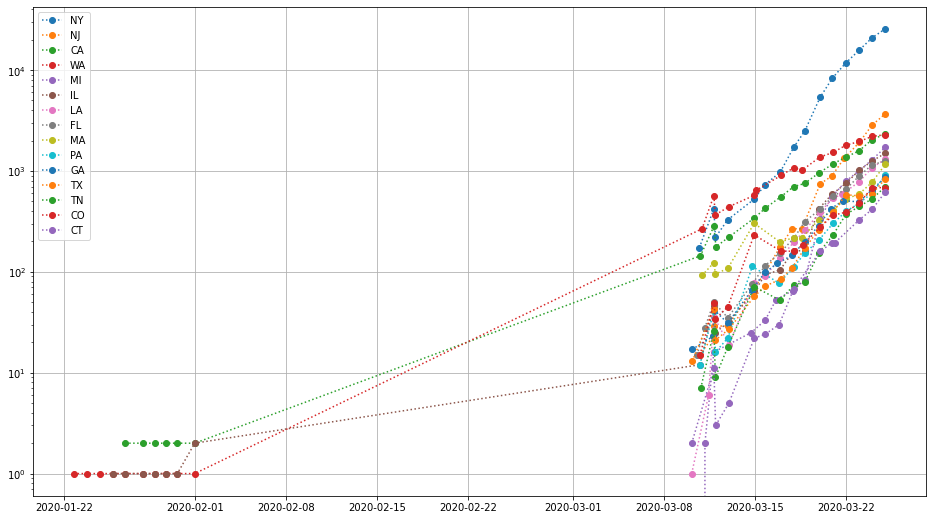

In [30]:
# You can modify this cell if you want to play around with the visualization.

viz_by_state("Confirmed", df_covid19_us, covid19_rankings[:TOP_K], logy=True)

Observe that this data is irregularly sampled and noisy. For instance, the updates do not occur every day in every state, and there are spikes due to reporting errors. Therefore, it would be useful to "smooth out" the data before plotting it, to help discern the overall trends better. That is your next task.

### Filling-in missing values ###

We'll do a first cleaning step for you: filling-in (or _imputing_) missing daily values, so that we have at least one value per day. To see the issue more clearly, consider the data for the state of Georgia:

In [31]:
df_covid19_us[df_covid19_us["ST"] == "GA"].sort_values(by="Timestamp")

,ST,Timestamp,Confirmed
133,GA,2020-03-10 03:53:03,17
134,GA,2020-03-11 18:52:03,23
135,GA,2020-03-11 20:00:00,42
136,GA,2020-03-12 21:39:10,31
137,GA,2020-03-14 17:53:03,66
138,GA,2020-03-15 18:20:19,99
139,GA,2020-03-16 16:53:06,121
140,GA,2020-03-17 20:13:22,146
141,GA,2020-03-18 19:14:34,199
142,GA,2020-03-19 21:13:35,287


There are two observations on March 11 and no observations on March 13. Suppose we want one value per day for every state. Our approach will be to _resample_ the values, using pandas built-in [resampler](https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#resampling), a standard cleaning method when dealing with irregularly sampled time-series data. There are many subtle options, so we will perform one method of resampling for you. The function below implements it, storing the results in a data frame called `df_us_daily`. You do not need to understand this code right, but do run it so you can see what it will do. It will print some example results for the state of Georgia data.

In [32]:
def resample_daily(df):
    # This implementation is a bit weird, due to a known issue: https://github.com/pandas-dev/pandas/issues/28313
    df_r = df.sort_values(by=["ST", "Timestamp"]) \
             .set_index("Timestamp") \
             .groupby("ST", group_keys=False) \
             .resample("1D", closed="right") \
             .ffill() \
             .reset_index()
    return df_r.sort_values(by=["ST", "Timestamp"]).reset_index(drop=True)
    
df_us_daily = resample_daily(df_covid19_us)
df_us_daily[df_us_daily["ST"] == "GA"]

,Timestamp,ST,Confirmed
222,2020-03-11,GA,17
223,2020-03-12,GA,42
224,2020-03-13,GA,31
225,2020-03-14,GA,31
226,2020-03-15,GA,66
227,2020-03-16,GA,99
228,2020-03-17,GA,121
229,2020-03-18,GA,146
230,2020-03-19,GA,199
231,2020-03-20,GA,287


Observe how there are now samples on every consecutive day beginning on March 11.

### Windowed daily averages ###

Armed with regularly sampled data, you can now complete the next step, which is to smooth out the data using _windowed daily averages_, defined as follows.

Let $c_t$ denote the number of confirmed cases on day $t$, and let $d$ be a positive integer. Then the $d$-day windowed daily average on day $t$, denoted $\bar{c}_t$, is the mean number of confirmed cases in the $d$ days up to and including day $t$. Mathematically,

$$
\bar{c}_t = \frac{c_{t-(d-1)} + c_{t-(d-2)} + \cdots + c_{t-1} + c_t}{d}.
$$

We'll refer to the values in the numerator as the _window_ for day $t$.

For example, suppose $c = [0, 0, 1, 2, 2, 3, 3, 4, 6, 10]$, where the first and last values are $c_0=0$ and $c_9=10$. Now suppose $d=3$ days. Then the windowed daily average on day $t$ is the average of confirmed cases on days $t-2$, $t-1$, and $t$:

$$
\bar{c}_4 = \frac{c_2 + c_3 + c_4}{3} = \frac{1 + 2 + 2}{3} = \frac{5}{3} = 1.666\ldots.
$$

In this example, there aren't 3-days worth of observations for days 0 and 1. Let's treat these cases as undefined, meaning there is no average computable for those days. Therefore, the final result in this example would be

$$
\bar{c} = [\mbox{nan}, \mbox{nan}, 0.333\ldots, 1.0, 1.666\ldots, 2.333\ldots, 2.666\ldots, 3.333\ldots, 4.333\ldots, 6.666\ldots],
$$

where $\mbox{nan}$ is a floating-point not-a-number value, which we will use a stand-in for an undefined average.

### Exercise 3 (3 points): Computing windowed daily averages ###

Suppose you are given a data frame `df` like `df_us_daily`, which `resample_daily()` computed. That is, you may assume `df` has three columns named `"Timestamp"`, `"ST"`, and `"Confirmed"`. However, **daily observations may appear in any order within `df`.** (That is, **do not** assume they are grouped by state or sorted by timestamp _a priori_.)

Please complete the function `daily_windowed_avg(df, days)` so that it calculates the windowed daily average using windows of size `days`. Your function should return a copy of `df` with a new column named `Avg` containing this average. For days with no defined average, your function should simply omit those days from the output.

> **Note.** Although the example below shows data only for `"GA"`, the input `df` may have more than one state's worth of data in it. Therefore, your function will need to handle that case.

For example, suppose the rows in `df` with Georgia data are as follows:

Timestamp|ST|Confirmed
---|---|---
2020-03-12|GA|42
2020-03-17|GA|121
2020-03-11|GA|17
2020-03-15|GA|66
2020-03-18|GA|146
2020-03-16|GA|99
2020-03-13|GA|31
2020-03-14|GA|31

Observe that the rows are not necessarily in timestamp order, so you'll need to deal with that. Among these rows, the first date is March 11 and the last is March 18.

Now, suppose we use `days=3` and call your function on the full dataset (with all states), and then look at just the Georgia rows, we should see

Timestamp|ST|Confirmed|Avg
---|---|---|---
2020-03-13|GA|31|30.000000
2020-03-14|GA|31|34.6666...
2020-03-15|GA|66|42.6666...
2020-03-16|GA|99|65.3333...
2020-03-17|GA|121|95.3333...
2020-03-18|GA|146|122.0000...

You can confirm that the first day of this result, March 13, 2020, is 30, which is the average of March 11-13 (17, 42, and 31 cases, respectively). The last day, March 18, is 122, the average of March 16-18 (99, 121, and 146 cases). March 11 and 12 do not appear because they do not have three days worth of observations.

> **Note 0.** There are many approaches to this problem. If you have good mastery of pandas, you should be able to quickly assimilate and apply its [built-in `.rolling()` technique](https://pandas.pydata.org/pandas-docs/stable/user_guide/groupby.html#window-and-resample-operations). Otherwise, it should also be straightforward to apply other techniques you already know.
>
> **Note 1.** To pass the autograder, you'll need to ensure that your data frame has exactly the columns shown in the above example. (We use tibble-equivalency checks so column and row ordering does not matter.)
>
> **Note 2.** The `.dtype` of columns `"Timestamp"`, `"ST"`, and `"Confirmed"` should match those of the input; the new column `"Avg"` contains floating-point values, and so should have a floating-point `.dtype`.
>
> **Note 3.** Our tester already does _approximate_ checking for floating-point values. Therefore, if the test code reports a mismatch, you are definitely miscalculating the averages by much more than the amount allowed by roundoff error, and you will have to keep debugging.

In [40]:
import pandas as pd

# Example DataFrame
df = pd.DataFrame({
    'timestamp': ['2023-01-01', '2023-01-03', '2023-01-04', '2023-02-01', '2023-01-05', '2023-01-02'],
    'value': [10, 20, 30, 40, 50, 5]
})

# Convert 'timestamp' to datetime
df['timestamp'] = pd.to_datetime(df['timestamp'])

df = df.sort_values(by='timestamp')

# Calculate a 3-day rolling average of the 'value' column, using 'timestamp' for the rolling window
df['rolling_avg'] = df.rolling(window='3D', on='timestamp', min_periods = 1)['value'].mean()

# Display the result
print(df.sort_index().dropna())


   timestamp  value  rolling_avg
1 2023-01-03     20    11.666667
2 2023-01-04     30    18.333333
4 2023-01-05     50    33.333333
5 2023-01-02      5     7.500000


In [60]:
def daily_windowed_avg(df_, days):
    df_avg= df_.sort_values(by='Timestamp').set_index('Timestamp')\
            .groupby('ST')\
            .rolling(days).mean()\
            .reset_index()\
            .rename(columns={'Confirmed':'Avg'}).dropna()
    return df_avg.merge(df_, on=['ST', 'Timestamp'])

In [61]:
# def daily_windowed_avg(df_, days):
#     df = df_.copy()
#     df['Timestamp'] = pd.to_datetime(df['Timestamp'])
#     df.sort_values(by='Timestamp', inplace=True)
#     df['Avg'] = df.rolling(window=f'{days}D', on='Timestamp', min_periods=3)['Confirmed'].mean()
#     return df.sort_index().dropna().drop_duplicates()

In [62]:
# # Demo of your function:
# print('=== Two states: "AK" and "GA" ===')
# is_ak_ga_before = df_us_daily["ST"].isin(["AK", "GA"])
# display(df_us_daily[is_ak_ga_before])

print('=== Your results (days=3) ===')
df_us_daily_avg = daily_windowed_avg(df_us_daily, 3)
is_ak_ga_after = df_us_daily_avg["ST"].isin(["AK", "GA"])
display(df_us_daily_avg[is_ak_ga_after])

=== Your results (days=3) ===


,ST,Timestamp,Avg,Confirmed
0,AK,2020-03-13,0.666667,1
1,AK,2020-03-14,1.000000,1
2,AK,2020-03-15,1.000000,1
3,AK,2020-03-16,1.000000,1
4,AK,2020-03-17,1.000000,1
5,AK,2020-03-18,1.666667,3
6,AK,2020-03-19,3.333333,6
7,AK,2020-03-20,6.000000,9
8,AK,2020-03-21,9.000000,12
9,AK,2020-03-22,12.000000,15


In [63]:
# Test cell: `ex3__daily_windowed_avg` (3 points)

###
### AUTOGRADER TEST - DO NOT REMOVE
###

def ex3_gen_state_df(st, days):
    from random import randint, random
    from pandas import DataFrame, concat
    from problem_utils import ex0_random_date
    def rand_day():
        from datetime import datetime
        date = ex0_random_date()
        return datetime(date.year, date.month, date.day)
    def inc_date(date, days=1):
        from datetime import timedelta
        return date + timedelta(days=days)
    dates = []
    sts = []
    confs = [randint(1, 10)]
    avgs = []
    r0 = 1 + random()
    day = rand_day()
    num_days = days + randint(1, 10)
    for k in range(num_days):
        dates.append(day)
        sts.append(st)
        confs.append(int(confs[0] * (r0**k)))
        if k >= days-1: avgs.append(sum(confs[(-days):]) / days)
        day = inc_date(day)
    df = DataFrame({"Timestamp": dates,
                    "ST": sts,
                    "Confirmed": confs[1:]})
    df_soln = DataFrame({"Timestamp": dates[(days-1):],
                         "ST": sts[(days-1):],
                         "Confirmed": confs[days:],
                         "Avg": avgs})
    return df, df_soln

def ex3_gen_df():
    from random import randint, sample
    from pandas import concat
    num_states = randint(1, 4)
    days = randint(1, 4)
    states = sample(STATE_NAMES["Abbrv"].tolist(), num_states)
    df_list = []
    df_soln_list = []
    for st in states:
        df_st, df_st_soln = ex3_gen_state_df(st, days)
        df_list.append(df_st)
        df_soln_list.append(df_st_soln)
    df = concat(df_list, ignore_index=True).sample(frac=1).reset_index(drop=True)
    df_soln = concat(df_soln_list, ignore_index=True).sort_values(by=["ST", "Timestamp"])
    try:
        df_your_soln = daily_windowed_avg(df, days)
        assert_tibbles_are_equivalent(df_soln, df_your_soln)
    except:
        print("\n*** ERROR ***")
        print("Input data frame:")
        display(df)
        print(f"Expected solution (days={days}):")
        display(df_soln)
        print("Your solution:")
        display(df_your_soln)
        raise

for trial in range(10):
    print(f"=== Trial #{trial} / 9 ===")
    ex3_gen_df()

print("\n(Passed.)")

=== Trial #0 / 9 ===
=== Trial #1 / 9 ===
=== Trial #2 / 9 ===
=== Trial #3 / 9 ===
=== Trial #4 / 9 ===
=== Trial #5 / 9 ===
=== Trial #6 / 9 ===
=== Trial #7 / 9 ===
=== Trial #8 / 9 ===


/mnt/vocwork3/work/eee_W_2747453/asn2398425_19/asn2398431_6/work/problem_utils.py:85: FutureWarning: The 'check_less_precise' keyword in testing.assert_*_equal is deprecated and will be removed in a future version. You can stop passing 'check_less_precise' to silence this warning.
  assert_frame_equal(A_c, B_c, check_index_type=False, check_less_precise=True)
/mnt/vocwork3/work/eee_W_2747453/asn2398425_19/asn2398431_6/work/problem_utils.py:85: FutureWarning: The 'check_less_precise' keyword in testing.assert_*_equal is deprecated and will be removed in a future version. You can stop passing 'check_less_precise' to silence this warning.
  assert_frame_equal(A_c, B_c, check_index_type=False, check_less_precise=True)
/mnt/vocwork3/work/eee_W_2747453/asn2398425_19/asn2398431_6/work/problem_utils.py:85: FutureWarning: The 'check_less_precise' keyword in testing.assert_*_equal is deprecated and will be removed in a future version. You can stop passing 'check_less_precise' to silence this war

=== Trial #9 / 9 ===

(Passed.)


/mnt/vocwork3/work/eee_W_2747453/asn2398425_19/asn2398431_6/work/problem_utils.py:85: FutureWarning: The 'check_less_precise' keyword in testing.assert_*_equal is deprecated and will be removed in a future version. You can stop passing 'check_less_precise' to silence this warning.
  assert_frame_equal(A_c, B_c, check_index_type=False, check_less_precise=True)


### (In case Exercise 3 isn't working) Daily windowed averages ###

In case you can't get a working solution to Exercise 3, we have pre-computed the daily windowed averages. The code cell below reads this data and stores it in the variable, `df_us_daily_avg`. You will need it in the subsequent exercises, so do not modify it!

In [64]:
with open(get_path('covid19/ex3_soln.csv'), "rt") as fp:
    df_us_daily_avg = pd.read_csv(get_path('covid19/ex3_soln.csv'), parse_dates=["Timestamp"])
df_us_daily_avg[df_us_daily_avg["ST"].isin(["AK", "GA"])]

,ST,Timestamp,Avg,Confirmed
0,AK,2020-03-13,0.666667,1
1,AK,2020-03-14,1.000000,1
2,AK,2020-03-15,1.000000,1
3,AK,2020-03-16,1.000000,1
4,AK,2020-03-17,1.000000,1
5,AK,2020-03-18,1.666667,3
6,AK,2020-03-19,3.333333,6
7,AK,2020-03-20,6.000000,9
8,AK,2020-03-21,9.000000,12
9,AK,2020-03-22,12.000000,15


Here is a visualization of the daily averages, which should appear smoother. As such, the trends should be a little more clear as well.

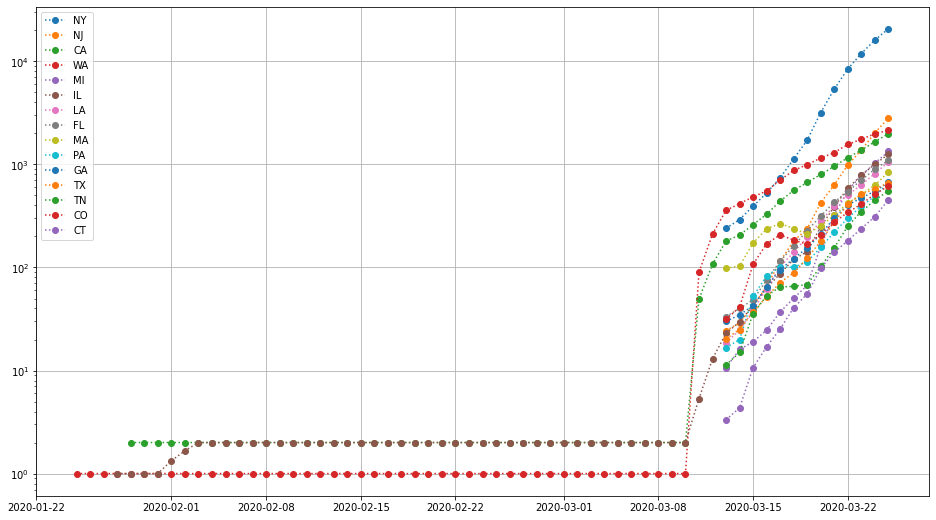

In [65]:
# You can modify this cell if you want to play around with the visualization.

viz_by_state("Avg", df_us_daily_avg, covid19_rankings[:TOP_K], logy=True)

## Step 2: Flights (re-)analysis

Recall from Notebook 11 that you used a Markov chain-based model to "rank" airport networks by how likely a certain "random flyer" is to end up at each airport. In this final step of this problem, you'll apply a similiar idea to rank states, and see how well it correlates with the state-by-state numbers of confirmed COVID-19 cases.

**Raw data.** First, observe that our raw data differs slightly from Notebook 11. It consists of all flights from calendar year 2019 (the latest available from the original source, as no 2020 flights are present there), and we've added a column with each airport's two-letter state postal code. Let's load these flights into a DataFrame called `flights`. (You don't need to understand this code in depth, but do pay attention to the format of the output sample from `flights`.)

In [66]:
def load_flights(infile=get_path('us-flights/us-flights-2019--86633396_T_ONTIME_REPORTING.csv')):
    keep_cols = ["FL_DATE", "ORIGIN_STATE_ABR", "DEST_STATE_ABR", "OP_UNIQUE_CARRIER", "OP_CARRIER_FL_NUM"]
    flights = pd.read_csv(infile)[keep_cols]
    us_sts = set(STATE_NAMES["Abbrv"])
    origin_is_state = flights['ORIGIN_STATE_ABR'].isin(us_sts)
    dest_is_state = flights['DEST_STATE_ABR'].isin(us_sts)
    return flights.loc[origin_is_state & dest_is_state].copy()

flights = load_flights()
print(f"There are {len(flights):,} direct flight segments in the `flights` data frame.")
print("Here are the first few:")
flights.head()

There are 7,352,434 direct flight segments in the `flights` data frame.
Here are the first few:


,FL_DATE,ORIGIN_STATE_ABR,DEST_STATE_ABR,OP_UNIQUE_CARRIER,OP_CARRIER_FL_NUM
0,2019-01-01,FL,NY,9E,5122
1,2019-01-01,NY,VA,9E,5123
2,2019-01-01,NC,GA,9E,5130
3,2019-01-01,GA,AL,9E,5136
4,2019-01-01,AL,GA,9E,5136


**Outdegrees.** In Notebook 11, we calculated the outdegree of each airport $u$ to be the number of distinct endpoints (other airports) reachable from $u$.

For the analysis in this problem, we will use a _different_ definition for the outdegree. In particular, we'll define the outdegree $d_u$ of **state** $u$ (e.g., the state of Georgia, the state of California) to be the total number of direct flight segments from state $u$ to all other states. In pandas, we can use a group-by-count aggregation to compute these outdegrees. Here is some code that does so, producing a data frame named `outdegrees` with two columns, the origin state (`"Origin"`) and outdegree value (`"Outdegree"`), sorted in descending order of outdegree. (You should be able to understand this code, which may help you in the next exercise.)

In [67]:
def calc_outdegrees(flights):
    outdegrees = flights[['ORIGIN_STATE_ABR', 'DEST_STATE_ABR']] \
                 .groupby(['ORIGIN_STATE_ABR']) \
                 .count() \
                 .reset_index() \
                 .rename(columns={'ORIGIN_STATE_ABR': 'Origin',
                                  'DEST_STATE_ABR': 'Outdegree'}) \
                 .sort_values(by='Outdegree', ascending=False) \
                 .reset_index(drop=True)
    return outdegrees

# Demo:
outdegrees = calc_outdegrees(flights)
print(f"There are {len(outdegrees)} states with a non-zero outdegree.")
print("Here are the first ten:")
outdegrees.head(10)

There are 49 states with a non-zero outdegree.
Here are the first ten:


,Origin,Outdegree
0,CA,814858
1,TX,802044
2,FL,569062
3,IL,442091
4,GA,419791
5,NY,385272
6,NC,339959
7,CO,282450
8,VA,270206
9,AZ,204998


### Exercise 4 (2 points): State transition probabilities ###

To run the ranking analysis, recall that we need to construct a probability transition matrix. For our state-to-state analysis, we therefore wish to estimate the probability of going from state $i$ to state $j$. Let's define that  probability to be the number of direct flight segments from state $i$ to state $j$ divided by the outdegree of state $i$.

Complete the function, `calc_state_trans_probs(flights, outdegrees)` to compute these state-to-state transition probabilities. Your function should accept two data frames like `flights` and `outdegrees` as defined above. In particular, you may assume the following;

- The `flights` data frame has three columns: `"ORIGIN_STATE_ABR"` (originating state, a two-letter abbreviation), `"DEST_STATE_ABR"` (destination state abbreviation), and `"FL_DATE"` (date of direct flight).
- The `outdegrees` data frame has two columns: `"Origin"` (originating state, a two-letter abbreviation) and `"Outdegree"` (an integer).

Your function should and return a new data frame with exactly these columns:

- `"Origin"`: The origin state, i.e., state $i$, as a two-letter abbreviation.
- `"Dest"`: The destination state, i.e., state $j$, as a two-letter abbreviation.
- `"Count"`: The number of direct flight segments from state $i$ to state $j$.
- `"TransProb"`: The transition probability of going from state $i$ to state $j$, i.e., the count divided by the outdegree.

In [68]:
def calc_state_trans_probs(flights, outdegrees):
    probs = flights[["ORIGIN_STATE_ABR","DEST_STATE_ABR","FL_DATE"]] \
    .groupby(["ORIGIN_STATE_ABR","DEST_STATE_ABR"]).count().reset_index()
    probs = probs.rename(columns={"ORIGIN_STATE_ABR": 'Origin', "DEST_STATE_ABR": 'Dest', "FL_DATE": 'Count'})\
    .merge(outdegrees, on = 'Origin', how='inner')
    probs['TransProb'] = probs['Count']/probs['Outdegree']
    del probs['Outdegree']
    return probs

In [69]:
# Demo, Part 0:
probs = calc_state_trans_probs(flights, outdegrees)
# print(f"There are {len(probs)} state-to-state transition probabilities in your result.")
# print("Here are ten with the largest transition probabilities:")
# display(probs.sort_values(by="TransProb", ascending=False).head(10))

In [70]:
# Demo, Part 1:

print("""
As a sanity check, let's see if the sum of all outgoing links per state
is (approximately) 1.0. If it isn't, meaning any of the rows of the
output below are `False`, use that information to help yourself debug.
""")
sanity = (probs[['Origin', 'TransProb']].groupby('Origin').sum() - 1.0).abs() < 1e-14
sanity


As a sanity check, let's see if the sum of all outgoing links per state
is (approximately) 1.0. If it isn't, meaning any of the rows of the
output below are `False`, use that information to help yourself debug.



,TransProb
Origin,
AK,True
AL,True
AR,True
AZ,True
CA,True
CO,True
CT,True
FL,True
GA,True


In [71]:
# Test cell: `ex4__calc_state_trans_probs` (2 points)

def ex4_gen_df_st(st):
    from random import randint, random, choice
    from collections import defaultdict
    from problem_utils import ex0_random_date
    from pandas import DataFrame
    states = list(STATE_NAMES["Abbrv"])
    num_unique_edges = randint(1, 4)
    dates = []
    dests = []
    counts = defaultdict(int)
    outdegree = 0
    for _ in range(num_unique_edges):
        if random() < 0.33:
            num_reps = randint(2, 4)
        else:
            num_reps = 1
        dest_st = choice(states)
        dests += [dest_st] * num_reps
        dates += [ex0_random_date() for _ in range(num_reps)]
        counts[(st, dest_st)] += num_reps
        outdegree += num_reps
    flights = DataFrame({"FL_DATE": dates,
                         "ORIGIN_STATE_ABR": [st] * len(dates),
                         "DEST_STATE_ABR": dests})
    dests_st = []
    counts_st = []
    probs_st = []
    for (st, dest_st), c in counts.items():
        dests_st.append(dest_st)
        counts_st.append(c)
        probs_st.append(c / outdegree)
    sts = [st] * len(dests_st)
    probs = DataFrame({"Origin": sts,
                       "Dest": dests_st,
                       "Count": counts_st,
                       "TransProb": probs_st})
    return flights, probs, outdegree

def ex4_check_one():
    from random import randint, sample
    from pandas import DataFrame, concat
    num_states = randint(1, 4)
    states = list(STATE_NAMES["Abbrv"])
    flights_list = []
    probs_list = []
    outdegrees_list = []
    sts = sample(states, num_states)
    for st in sts:
        flights_st, probs_st, outdegree_st = ex4_gen_df_st(st)
        flights_list.append(flights_st)
        probs_list.append(probs_st)
        outdegrees_list.append(outdegree_st)
    flights = concat(flights_list, ignore_index=True) \
              .sort_values(by="FL_DATE") \
              .reset_index(drop=True)
    probs = concat(probs_list, ignore_index=True) \
            .sort_values(by="Origin") \
            .reset_index(drop=True)
    outdegrees = DataFrame({"Origin": sts,
                            "Outdegree": outdegrees_list})
    try:
        your_probs = calc_state_trans_probs(flights, outdegrees)
        assert_tibbles_are_equivalent(probs, your_probs)
    except:
        print("\n*** ERROR ***\n")
        print("`flights` input:")
        display(flights)
        print("`outdegrees` input:")
        display(outdegrees)
        print("Expected output:")
        display(probs)
        print("Your output:")
        display(your_probs)
        raise
    
for trial in range(10):
    print(f"=== Trial #{trial} / 9 ===")
    ex4_check_one()

EXERCISE4_PASSED = True
print("\n(Passed.)")

=== Trial #0 / 9 ===
=== Trial #1 / 9 ===
=== Trial #2 / 9 ===
=== Trial #3 / 9 ===
=== Trial #4 / 9 ===
=== Trial #5 / 9 ===
=== Trial #6 / 9 ===
=== Trial #7 / 9 ===
=== Trial #8 / 9 ===
=== Trial #9 / 9 ===

(Passed.)


/mnt/vocwork3/work/eee_W_2747453/asn2398425_19/asn2398431_6/work/problem_utils.py:85: FutureWarning: The 'check_less_precise' keyword in testing.assert_*_equal is deprecated and will be removed in a future version. You can stop passing 'check_less_precise' to silence this warning.
  assert_frame_equal(A_c, B_c, check_index_type=False, check_less_precise=True)
/mnt/vocwork3/work/eee_W_2747453/asn2398425_19/asn2398431_6/work/problem_utils.py:85: FutureWarning: The 'check_less_precise' keyword in testing.assert_*_equal is deprecated and will be removed in a future version. You can stop passing 'check_less_precise' to silence this warning.
  assert_frame_equal(A_c, B_c, check_index_type=False, check_less_precise=True)
/mnt/vocwork3/work/eee_W_2747453/asn2398425_19/asn2398431_6/work/problem_utils.py:85: FutureWarning: The 'check_less_precise' keyword in testing.assert_*_equal is deprecated and will be removed in a future version. You can stop passing 'check_less_precise' to silence this war

### (In case Exercise 4 isn't working) ###

The rest of this notebook completes the comparison between state-rankings by confirmed cases and those by the airport network. It does depend on a working Exercise 4. However, running it is for your edification only, as there are no additional exercises or test cells below. Nevertheless, if the autograder has trouble completing due to errors in the code below, you can try converting the code cells to Markdown (effectively disabling them) and see if that helps.

**State rankings.** The next code cell runs the PageRank-style algorithm on the state-to-state airport network and produces a ranking. It depends on a correct result for Exercise 4, so if yours is not working completely, it might not run to completion. If that causes issues with the autograder, you can try converting the cell to Markdown to (effectively) disable it.

In [72]:
def spy(A, figsize=(6, 6), markersize=0.5):
    """Visualizes a sparse matrix."""
    from matplotlib.pyplot import figure, spy, show
    fig = figure(figsize=figsize)
    spy(A, markersize=markersize)
    show()
    
def display_vec_sparsely(x, name='x'):
    from numpy import argwhere
    from pandas import DataFrame
    i_nz = argwhere(x).flatten()
    df_x_nz = DataFrame({'i': i_nz, '{}[i] (non-zero only)'.format(name): x[i_nz]})
    display(df_x_nz.head(5))
    if len(df_x_nz) > 5:
        print("...")
        display(df_x_nz.tail(5))

def eval_markov_chain(P, x0, t_max):
    x = x0
    for t in range(t_max):
        x = P.T.dot(x)
    return x

def rank_states_by_air_network(probs, t_max=100, verbose=True):
    from numpy import array, zeros, ones, argsort, arange
    from scipy.sparse import coo_matrix
    from pandas import DataFrame

    # Create transition matrix
    unique_origins = set(probs['Origin'])
    unique_dests = set(probs['Dest'])
    unique_states = array(sorted(unique_origins | unique_dests))
    state_ids = {st: i for i, st in enumerate(unique_states)}
    num_states = max(state_ids.values()) + 1
    
    s2s = probs.copy()
    s2s['OriginID'] = s2s['Origin'].map(state_ids)
    s2s['DestID'] = s2s['Dest'].map(state_ids)
    
    P = coo_matrix((s2s['TransProb'], (s2s['OriginID'], s2s['DestID'])),
                   shape=(num_states, num_states))
    if verbose: spy(P)

    # Run ranking algorithm
    x0 = zeros(num_states)
    x0[state_ids['WA']] = 1.0 # First state to report confirmed COVID-19 cases
    
    if verbose:
        print("Initial condition:")
        display_vec_sparsely(x0, name='x0')
        
    x = eval_markov_chain(P, x0, t_max)

    if verbose:
        print("Final probabilities:")
        display_vec_sparsely(x)
        
    # Produce a results table of rank-ordered states
    ranks = argsort(-x)
    df_ranks = DataFrame({'Rank': arange(1, len(ranks)+1),
                          'State': unique_states[ranks],
                          'x(t)': x[ranks]})
    df_ranks['ID'] = df_ranks['State'].map(state_ids)
        
    return df_ranks

if "EXERCISE4_PASSED" in dir() and EXERCISE4_PASSED:
    print("Running the ranking algorithm...")
    airnet_rankings = rank_states_by_air_network(probs, verbose=False)

    print(f"==> Here are the top-{TOP_K} states:")
    display(airnet_rankings.head(TOP_K))
else:
    print("We did not detect that the Exercise 4 test cell passed, so we aren't running this cell.")

Running the ranking algorithm...
==> Here are the top-15 states:


,Rank,State,x(t),ID
0,1,CA,0.110829,4
1,2,TX,0.109096,41
2,3,FL,0.077404,7
3,4,IL,0.060123,12
4,5,GA,0.057099,8
5,6,NY,0.052398,32
6,7,NC,0.046237,25
7,8,CO,0.038418,5
8,9,VA,0.036742,43
9,10,AZ,0.027885,3


**Comparing the two rankings.** We now have a ranking of states by number of confirmed COVID-19 cases, as well as a separate ranking of states by air-network connectivity. To compare them, we'll use a measure called [_rank-biased overlap_ (RBO)](https://doi.org/10.1145/1852102.1852106). Very roughly speaking, this measure is an estimate of the probability that a reader comparing the top few entries of two rankings tends to encounter the same items, so a value closer to 1 means the top entries of the two rankings are more similar.

> **Note 0.** We say "top few" above because RBO is parameterized by a "patience" parameter, which is related to how many of the top entries the reader will inspect before stopping. The reason for this parameter originates in the motivation for RBO, which was to measure the similarity between search engine results. The code we are using to calculate RBO uses [this implementation](https://github.com/dlukes/rbo)).
>
> **Note 1.** This cell should only be run if Exercise 4 passes.

In [73]:
from rbo import rbo

if "EXERCISE4_PASSED" in dir() and EXERCISE4_PASSED:
    compare_rankings = rbo(covid19_rankings, # ranking by confirmed COVID-19 cases
                           airnet_rankings['State'].values, # ranking by air-network connectivity
                           0.95) # "patience" parameter
    print(f"Raw RBO result: {compare_rankings}\n\n==> RBO score is {compare_rankings.ext:.3}")
else:
    print("We did not detect that the Exercise 4 test cell passed, so we aren't running this cell.")

Raw RBO result: RBO(min=0.5783307042800485, res=0.02058258852563008, ext=0.5987896438055367)

==> RBO score is 0.599


If everything is correct, you'll see an RBO score of around 0.6, which suggests that the connectivity of the airport network may help explain the number of confirmed COVID-19 cases we are seeing in each state.

**Fin!** You’ve reached the end of this problem. Don’t forget to restart and run all cells again to make sure it’s all working when run in sequence; and make sure your work passes the submission process. Good luck!